In [9]:
import pickle
import plotly.express as px
import numpy as np
import cv2
import json
from tqdm.notebook import tqdm
import einops
import matplotlib.pyplot as plt
from pathlib import Path
import os
import torch
from skimage.measure import find_contours
from visualization_utils.visualization import draw_on_image

from blender_cv_utils.projection_camera import apply_object_matrix_world, project_points

In [10]:
camera_name = 'Camera.001'

In [11]:
path = 'C:/Users/ivand/Desktop/output_temp/default_sc1/'

global_params = json.load(open(os.path.join(path, 'global_params.json'), 'r'))

all_data = []
for annot_path in tqdm(sorted(Path(path).rglob('annots_frame*.json'))):
     n = int(annot_path.name.replace('annots_frame', '').replace('.json', ''))
     im = cv2.imread(os.path.join(path, f'{camera_name}_{n:04}.png'))
     data = json.load(
         open(os.path.join(path, f'annots_frame{n:04}.json'), 'r'))
     data[camera_name].update(global_params)

     objects_data = {}
     for index, i in enumerate(['Armature', 'Armature.001', 'Armature.002', 'Armature.003', 'Armature.004', ]):
          skeleton = []
          for name, bone in data[i]['pose'].items():
              if name in ['Bone.012.R.001', 'Bone.012.L.001', 'Bone.008.R.001', 'Bone.008.L.001', 'Bone.020']:  # IK bones
                  continue
              points = np.stack([np.array(bone['head']), np.array(bone['tail'])])
              points = apply_object_matrix_world(points, data[i]['matrix_world'])
              points = project_points(points, **data[camera_name]).numpy()
              dh = torch.dist(torch.tensor(np.array(data[camera_name]['matrix_world'])[:-1,3]), torch.tensor(bone['head']), p=2).item()
              dt = torch.dist(torch.tensor(np.array(data[camera_name]['matrix_world'])[:-1,3]), torch.tensor(bone['tail']), p=2).item()
              points = np.concatenate((points, np.array([dh,dt])[...,None]), axis=1)
              skeleton.append(points)

          mesh = data[data[i]['childrens'][0]]
          mask = plt.imread(os.path.join(path, mesh["name"], f'{camera_name}_{n:04}.png'))
          mask = (mask[:,:,0] > 0.01).astype(np.uint8)
        #   xraymask = plt.imread(os.path.join(path, mesh["name"], f'xray_{camera_name}_{n:04}.png'))[:, :, 3]

          im = draw_on_image(im, mask)
       
          contours = find_contours(mask.T, 0.5)
          contours = [np.array(i).round().astype(np.int32) for i in contours]
          contours = np.concatenate(contours)
          xmin, xmax = np.min(contours[:, 0]), np.max(contours[:, 0])
          ymin, ymax = np.min(contours[:, 1]), np.max(contours[:, 1])
          objects_data[i] = {
              'box':(xmin, ymin, xmax, ymax),
              'mask':mask[ymin:ymax, xmin:xmax],
              'sk':np.stack(skeleton)[:, 0, :],  # select only heads
              'impath':os.path.join(path, f'{camera_name}_{n:04}.png'),
          }

     all_data.append(objects_data)
    #  break

  0%|          | 0/999 [00:00<?, ?it/s]

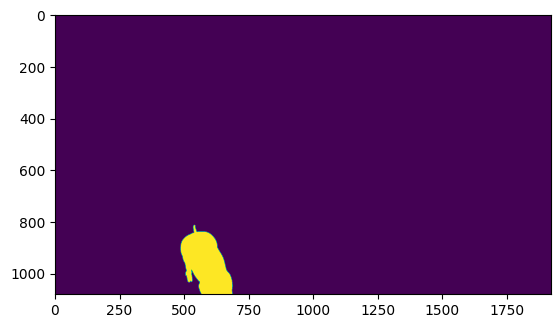

In [12]:
plt.imshow(mask)

In [13]:
pickle.dump(all_data, open(f'{path}/tempdata.pickle', 'wb'))

In [14]:
data['Armature']['default_data']['Bone.012.R.001'].keys()

dict_keys(['head_local', 'head', 'tail_local', 'tail', 'matrix', 'matrix_local'])